In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py
main_dir = os.path.abspath('../')
sys.path.append(main_dir)

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator
from utils.modes.vortex import Vortex


device = 'cuda:2'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


truncate_circle = True

## Load the Data and extract the derivatives

In [2]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/Nils_salamanca_vortex_data/'
bitdepth = 16

files = os.listdir(dir)
files =[f for f in files if f.endswith('.npy') and 'HS' not in f]

files_dict = {str(i):files[i] for i in range(len(files))}
print(files_dict)
cali_idx = 1
cali_file = files.pop(cali_idx)
relfiles = np.sort(files)[:1]

calibration_measurement = (np.stack(np.load(dir + cali_file,allow_pickle=True)) / 2**bitdepth).astype(np.float32)
measurements =np.stack([(np.stack(np.load(dir + file,allow_pickle=True)) / 2**bitdepth).astype(np.float32) for file in relfiles])

{'0': 'sig_stack_mean_cropped.npy', '1': 'ref_stack_mean_cropped.npy', '2': 'sig_stack_mean_vortex2.npy'}


(-0.5, 1314.5, -0.5, 1314.5)

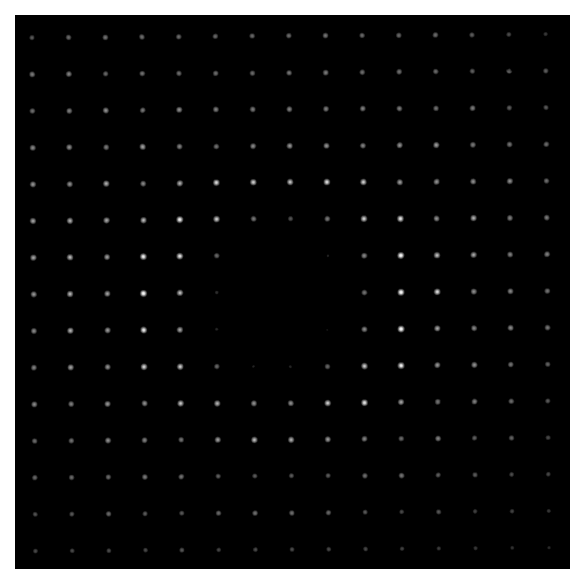

In [3]:
wl = 1
calibration_measurement = calibration_measurement[wl]
measurements = measurements[0,wl]

plt.figure(dpi=150)
# plt.imshow(calibration_measurement,cmap='Greys_r'); plt.axis('off')
# plt.imshow(measurements,cmap='Reds',alpha=.4)
plt.imshow(measurements,cmap='Greys_r', origin='lower'); plt.axis('off')

### Extract the peaks from the calibration and data measurement.

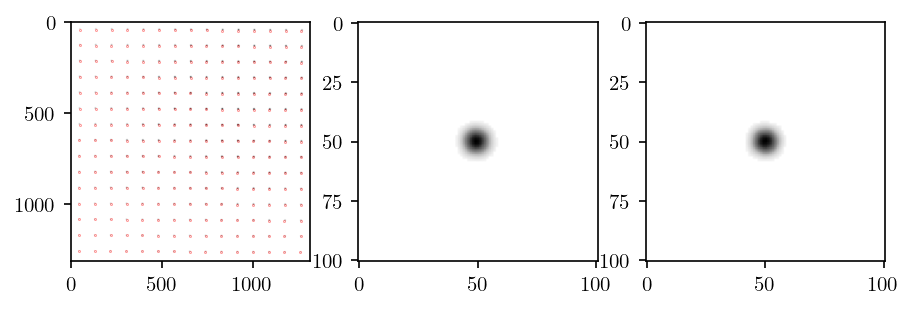

In [4]:
from skimage.feature import peak_local_max

peak_locs = peak_local_max(calibration_measurement, min_distance=30,threshold_rel=0.1)

border = 50

cali_peaks = []
data_peaks = []

for loc in peak_locs:
    cali_peaks.append(calibration_measurement[loc[0]-border:loc[0]+border+1,loc[1]-border:loc[1]+border+1])
    data_peaks.append(measurements[loc[0]-border:loc[0]+border+1,loc[1]-border:loc[1]+border+1])

fig,ax = plt.subplots(1,3,dpi=150,figsize=(7,3))
ax[0].imshow(calibration_measurement,cmap='Greys')
ax[0].scatter(peak_locs[:,1],peak_locs[:,0],c='r',s=.03)
ax[1].imshow(data_peaks[0],cmap='Greys')
ax[2].imshow(cali_peaks[0],cmap='Greys')

In [5]:
# put all the peak_locs onto a grid.

bins = np.linspace(0,calibration_measurement.shape[0],16)
digitized = np.digitize(peak_locs,bins) - 1

now calculate the center of mass of each. 

In [6]:
from scipy.ndimage import center_of_mass

deltas = np.stack([np.array(center_of_mass(data_peaks[i])) - np.array(center_of_mass(cali_peaks[i]))  for i in range(len(cali_peaks))])

nans = np.isnan(deltas).any(axis=1)

deltas = deltas[~nans]
digitized = digitized[~nans]
peak_locs = peak_locs[~nans]

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:1535: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


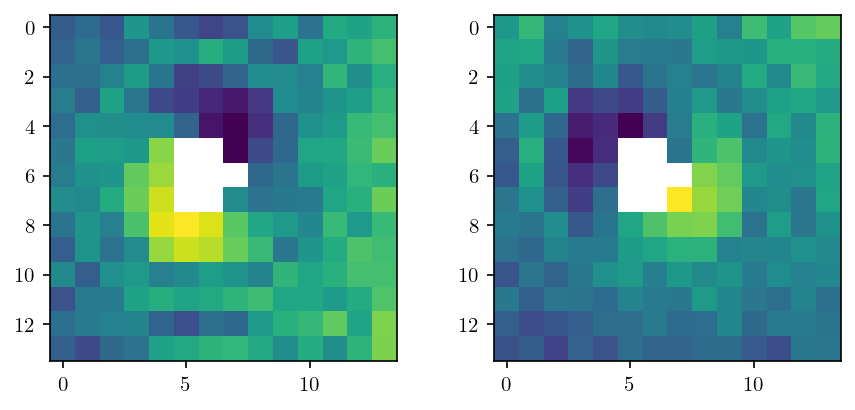

In [7]:
wavefront_derivs = np.ones((2,15,15)) * np.nan
for n,cell in enumerate(digitized):
    wavefront_derivs[0,cell[0],cell[1]] = deltas[n,0]
    wavefront_derivs[1,cell[0],cell[1]] = deltas[n,1]

wavefront_derivs = wavefront_derivs[:,1:, 1:]

fig,ax = plt.subplots(1,2,dpi=150,figsize=(7,3))
ax[0].imshow(wavefront_derivs[0])
ax[1].imshow(wavefront_derivs[1])



## From here I show once we have gradients


In [8]:
wl = 800e-9
focal_length = 14.2e-3
pixelsize = 3.45e-6
microlens_pitch = 300e-6

sampled_gradient = torch.tensor(wavefront_derivs) *  pixelsize / focal_length * 2*np.pi / wl
size = wavefront_derivs.shape[2]
n_zernike_rows = 5
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2



num_inits = 25

evaller = ModalEvaluator(size=(size,size), initializations=num_inits, n_zernike_rows=n_zernike_rows, zern_transform=False, pixel_basis=True, special_mode=Vortex,
                            microlens_pitch=microlens_pitch, device=device)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
init_transX, init_transY = np.meshgrid(np.linspace(-.02, .02, 5), np.linspace(-.02, .02, 5))
init_rot = np.array([0]*num_inits) #np.repeat(np.linspace(0, 2*np.pi, 5), 5)

init_rot, init_transX, init_transY = init_rot, init_transX.flatten(), init_transY.flatten()

coeffs, history = evaller.fit(sampled_gradient, affine_initialization=[init_rot, init_transX, init_transY], epochs=8000, lr=5e-3, l1_reg=1.6e-4)

/home/s/Sunny.Howard/overdictionary/utils/models/modalevaluator.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavefront_derivs = torch.tensor(wavefront_derivs).permute(1,0).tile(self.initializations,1).float().to(self.device)


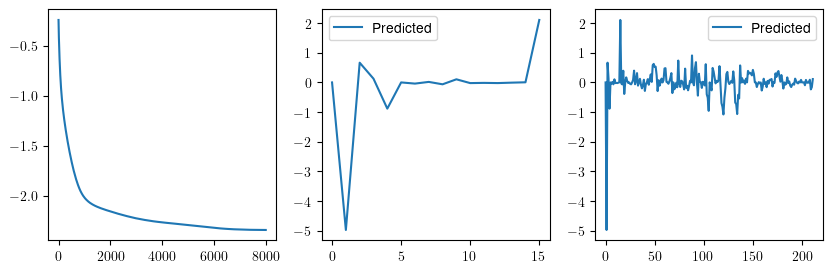

In [10]:
fig,ax = plt.subplots(1,3, figsize = (10,3))
ax[0].plot(np.log10(history['loss']))
ax[1].plot(coeffs['coefficients'][evaller.best_init,:n_zernike+1].detach().cpu())
ax[1].legend(['Predicted'])
ax[2].plot(coeffs['coefficients'][evaller.best_init,:].detach().cpu())
ax[2].legend(['Predicted'])

In [11]:
coeffs['coefficients'][evaller.best_init,:].detach().cpu()[n_zernike]


tensor(2.1054)

In [12]:
print(history['per_init_loss'])

[0.01337126 0.00322247 0.00323467 0.00327989 0.00322324 0.00323391
 0.00323474 0.0032329  0.00323361 0.00322347 0.00323535 0.00323967
 0.00327304 0.00323372 0.00327299 0.00322352 0.00322526 0.00322331
 0.00324042 0.00327289 0.00327938 0.00327981 0.00323916 0.00323469
 0.00327297]


In [13]:
wavefront_pred, derivs_pred =  evaller.get_wavefront(coeffs, microlens_pitch=1)

/home/s/Sunny.Howard/overdictionary/utils/models/affinemodel.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transX_list = nn.Parameter(torch.tensor(theta[:,0,2].clone().detach()))
/home/s/Sunny.Howard/overdictionary/utils/models/affinemodel.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transY_list = nn.Parameter(torch.tensor(theta[:,1,2].clone().detach()))
/home/s/Sunny.Howard/overdictionary/utils/models/affinemodel.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rot_list = nn.Parameter(torch.tensor(angle

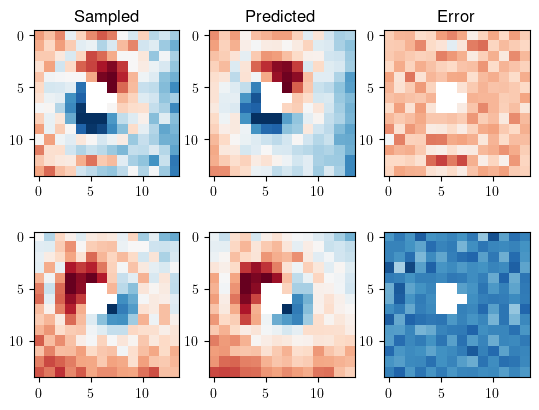

In [14]:
vmax = torch.nan_to_num(sampled_gradient[0]).max()*.9
vmin = torch.nan_to_num(sampled_gradient[0]).min()*.9

fig,ax = plt.subplots(2,3,dpi=100)
ax[0,0].imshow(sampled_gradient[0],cmap='RdBu',vmax=vmax, vmin=vmin); ax[0,0].set_title('Sampled')
ax[0,1].imshow(derivs_pred[0],cmap='RdBu',vmax=vmax, vmin=vmin); ax[0,1].set_title('Predicted')
ax[0,2].imshow(sampled_gradient[0]-derivs_pred[0],cmap='RdBu',vmax=vmax, vmin=vmin); ax[0,2].set_title('Error')

vmax = torch.nan_to_num(sampled_gradient[1]).max()*.9
vmin = torch.nan_to_num(sampled_gradient[1]).min()*.9

ax[1,0].imshow(sampled_gradient[1],cmap='RdBu',vmax=vmax, vmin=vmin)
ax[1,1].imshow(derivs_pred[1],cmap='RdBu',vmax=vmax, vmin=vmin)
ax[1,2].imshow(sampled_gradient[1]-derivs_pred[1],cmap='RdBu',vmax=vmax, vmin=vmin)

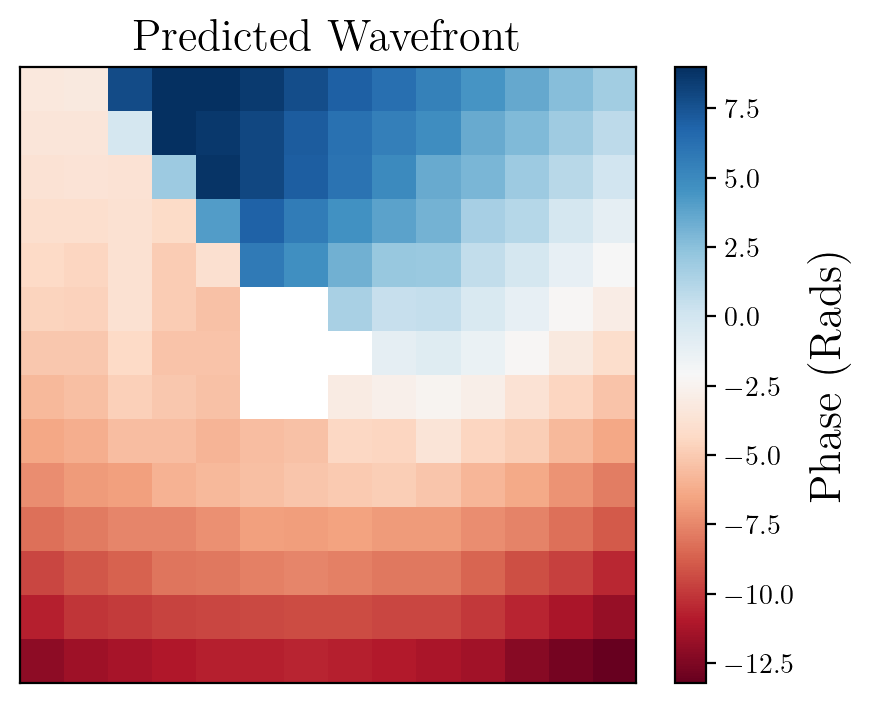

In [25]:
vmax = np.nan_to_num(wavefront_pred).max()
vmin = np.nan_to_num(wavefront_pred).min()

fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=200)
im = ax.imshow(wavefront_pred,vmax=vmax,vmin=vmin, cmap='RdBu'); ax.set_title('Predicted Wavefront', fontsize=16); ax.set_xticks([]); ax.set_yticks([])

#make color bar with label
cbar = plt.colorbar(im)
cbar.set_label('Phase (Rads)', fontsize = 16)


#(wavefront_pred/wavefront).mean(), (wavefront_pred/wavefront).std()

In [16]:
evaller.aff_model.rot_list[evaller.best_init + num_inits]

tensor(0.6196, device='cuda:2', grad_fn=<SelectBackward0>)

In [17]:
coeffs['coefficients'][evaller.best_init,:].detach().cpu().shape

torch.Size([212])

In [18]:
from matplotlib import rc

# Set the font family to serif and specify Times New Roman
rc('font',**{'family':'serif','serif':['CMU Serif Roman']})
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# Enable LaTeX for text rendering
rc('text', usetex=True)

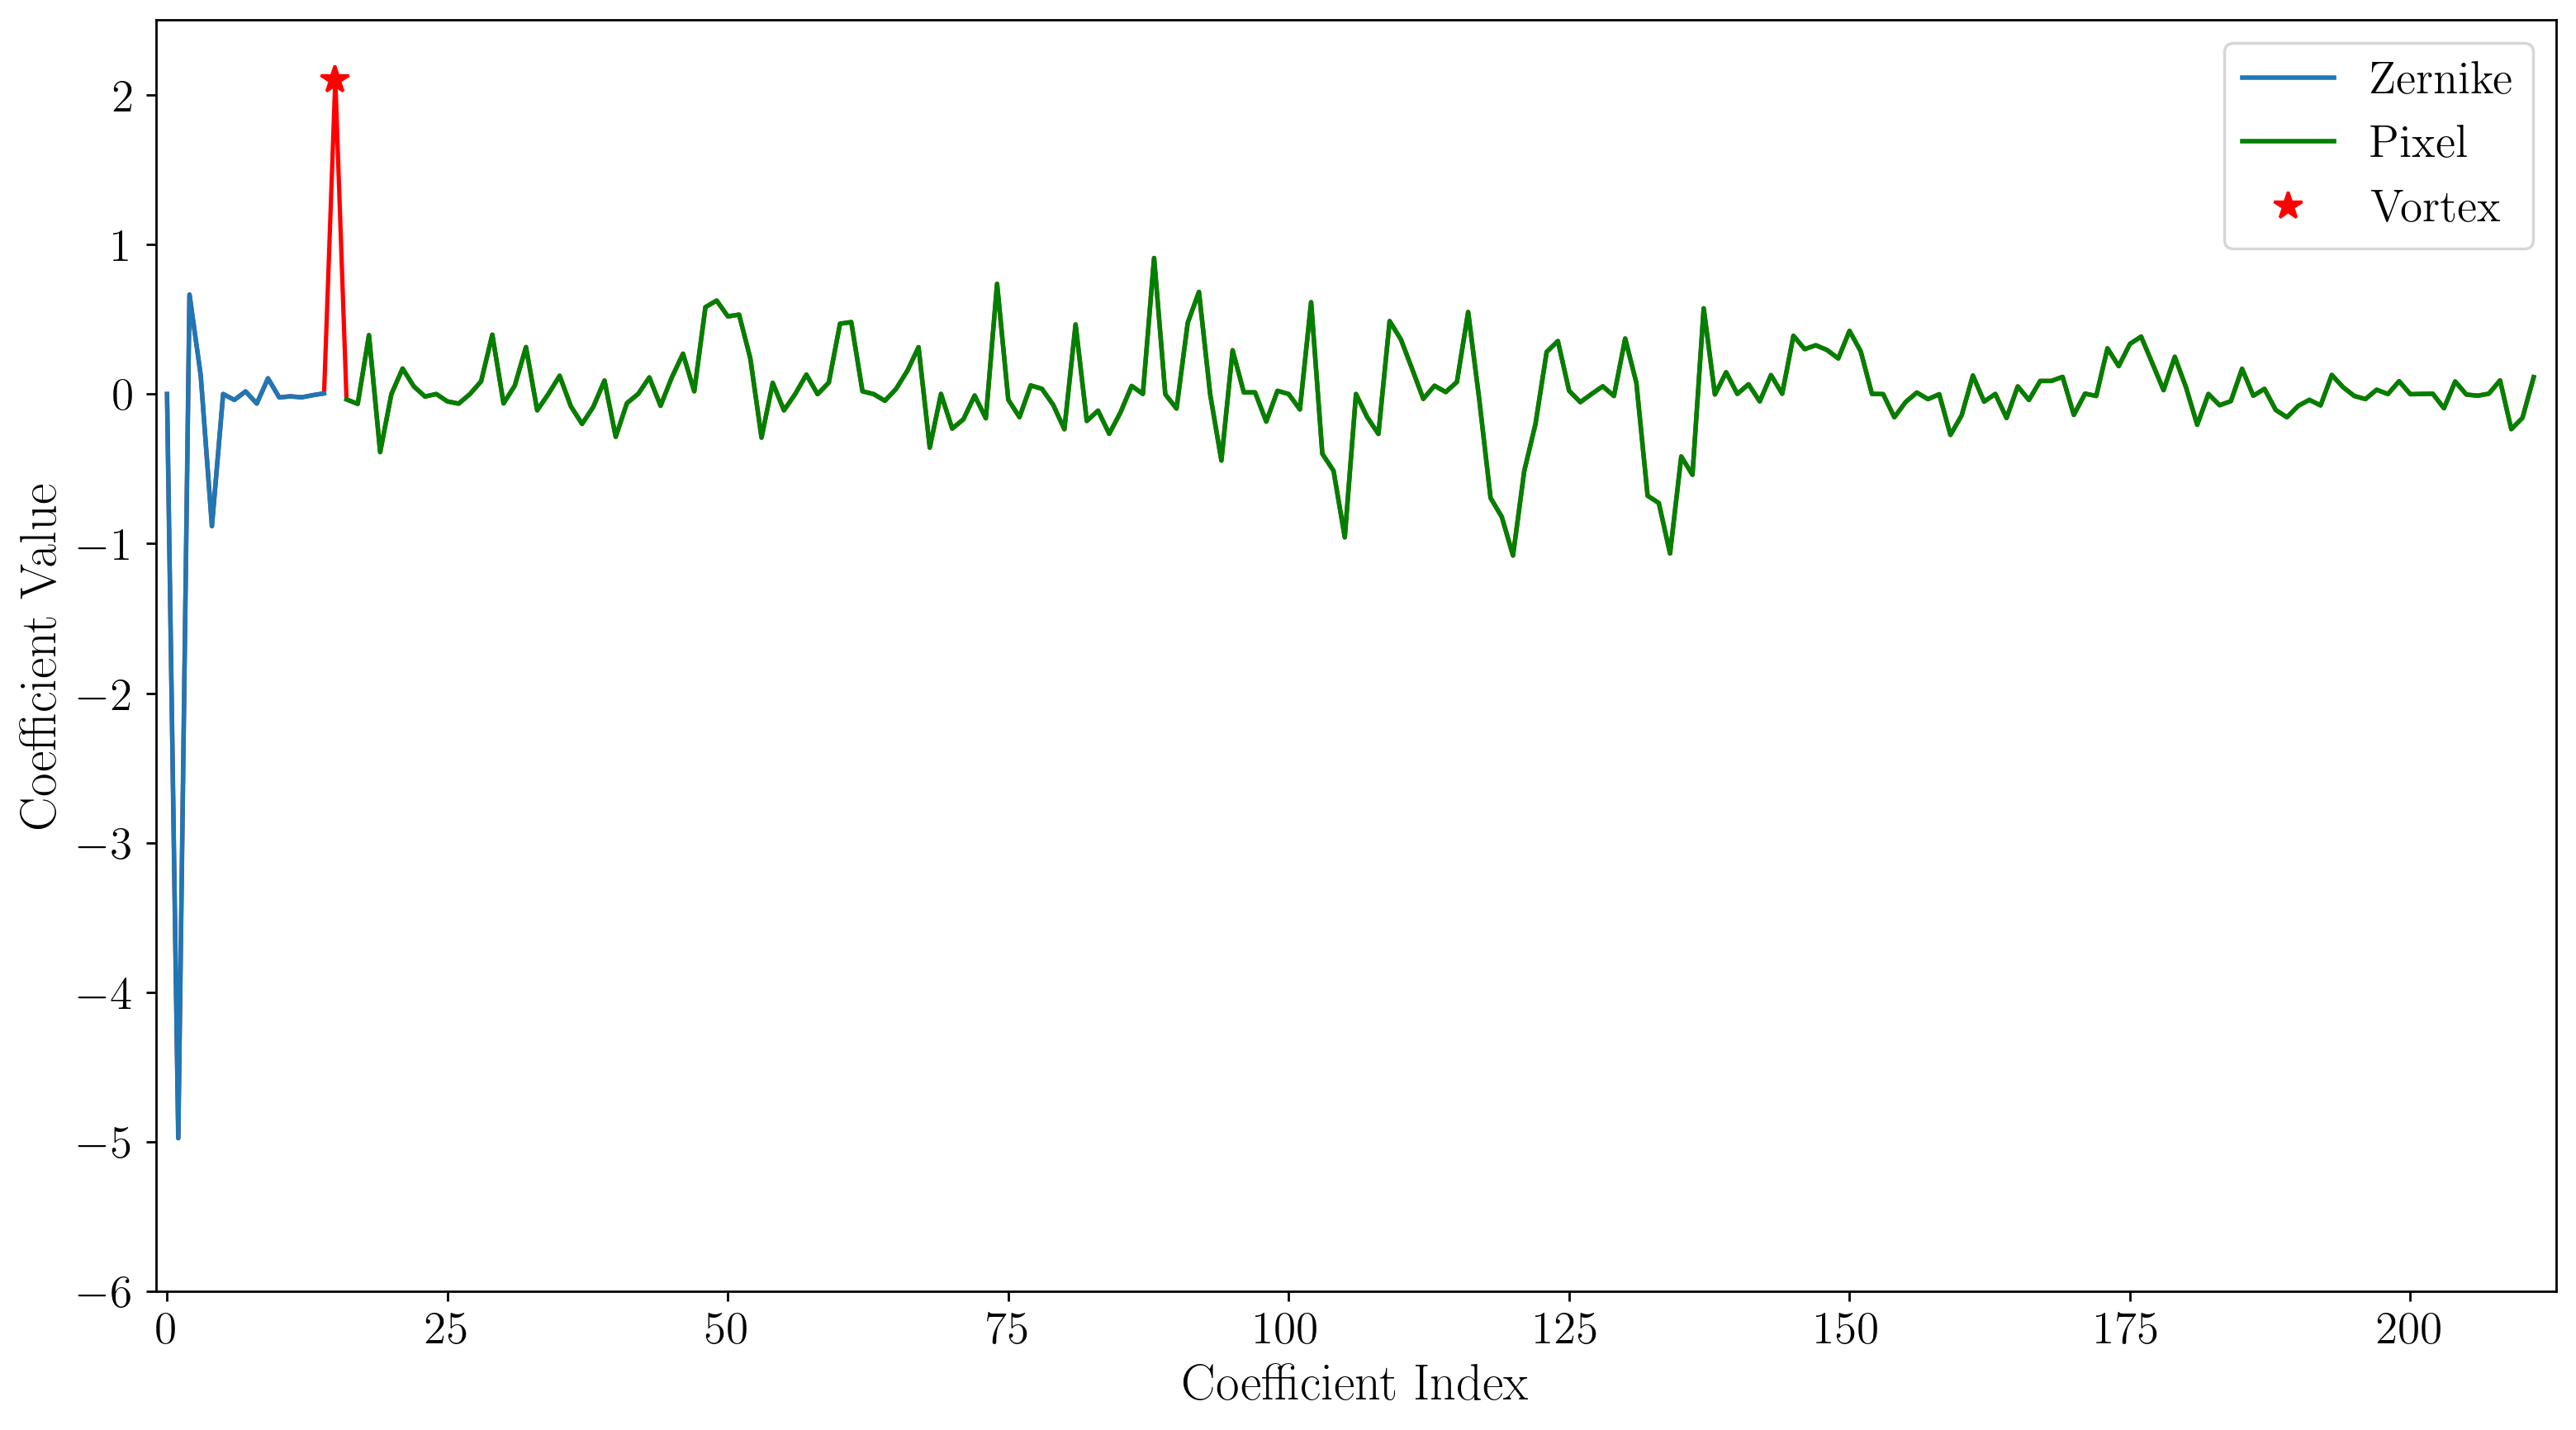

In [19]:
fig,ax = plt.subplots(1,1,figsize = (15,8), dpi=250)
ax.plot(coeffs['coefficients'][evaller.best_init,:].detach().cpu(), 'r')
ax.plot(coeffs['coefficients'][evaller.best_init,:n_zernike].detach().cpu(), label='Zernike', linewidth=1.6)
ax.plot(np.arange(n_zernike+1, 212), coeffs['coefficients'][evaller.best_init,n_zernike+1:].detach().cpu(), 'g', linewidth=1.6, label='Pixel')
ax.plot(n_zernike-.1, coeffs['coefficients'][evaller.best_init,n_zernike].detach().cpu(), 'r*', markersize=10, label='Vortex')
ax.legend(fontsize=16)
ax.set_xlim(-1, 213)
ax.set_ylim(-6, 2.5)
ax.set_ylabel('Coefficient Value', fontsize=18)
ax.set_xlabel('Coefficient Index', fontsize=18)

#change xtick size to larger
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

In [20]:
from matplotlib import rc

# Set the font family to serif and specify Times New Roman
rc('font',**{'family':'serif','serif':['CMU Serif Roman']})
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# Enable LaTeX for text rendering
rc('text', usetex=True)

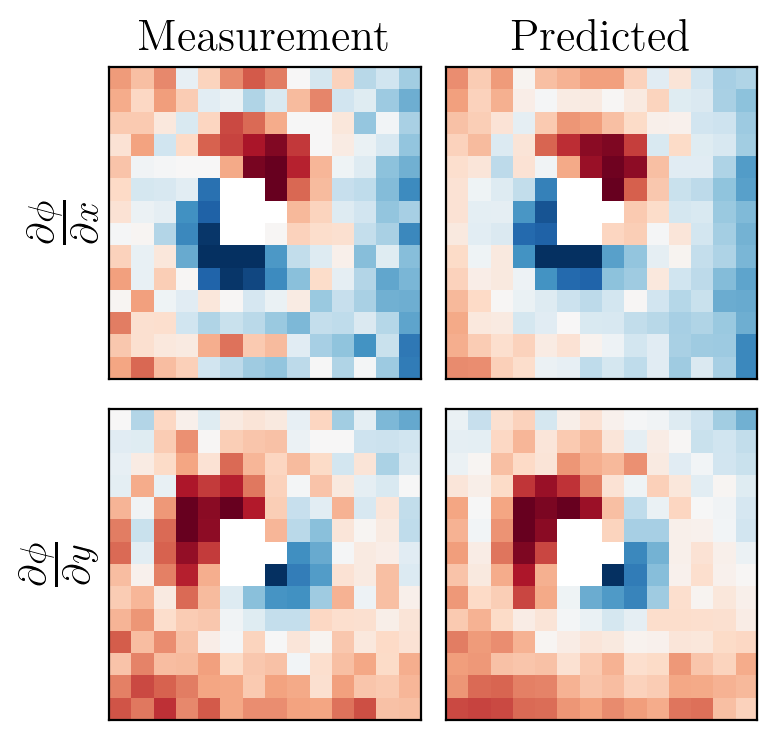

In [21]:
vmax = torch.nan_to_num(sampled_gradient[0]).max()*.9
vmin = torch.nan_to_num(sampled_gradient[0]).min()*.9

fig,ax = plt.subplots(2,2,figsize = (4,3.8  ), dpi=200)
ax[0,0].imshow(sampled_gradient[0],cmap='RdBu',vmax=vmax, vmin=vmin); ax[0,0].set_title('Measurement', fontsize=16);ax[0,0].set_yticks([]);ax[0,0].set_xticks([]); ax[0,0].set_ylabel(r'$\frac{\partial \phi}{\partial x}$', fontsize=20)
ax[0,1].imshow(derivs_pred[0],cmap='RdBu',vmax=vmax, vmin=vmin);  ax[0,1].set_yticks([]);ax[0,1].set_xticks([]);ax[0,1].set_title('Predicted', fontsize=16);

vmax = torch.nan_to_num(sampled_gradient[1]).max()*.9
vmin = torch.nan_to_num(sampled_gradient[1]).min()*.9

ax[1,0].imshow(sampled_gradient[1],cmap='RdBu',vmax=vmax, vmin=vmin);   ax[1,0].set_yticks([]);ax[1,0].set_xticks([]); ax[1,0].set_ylabel(r'$\frac{\partial \phi}{\partial y}$', fontsize=20)
ax[1,1].imshow(derivs_pred[1],cmap='RdBu',vmax=vmax, vmin=vmin); ax[1,1].set_yticks([]);ax[1,1].set_xticks([])

plt.tight_layout()

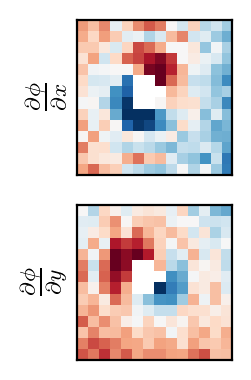

In [22]:
vmax = torch.nan_to_num(sampled_gradient[0]).max()*.9
vmin = torch.nan_to_num(sampled_gradient[0]).min()*.9

fig,ax = plt.subplots(2,1,figsize = (4,2  ), dpi=200)
ax[0].imshow(sampled_gradient[0],cmap='RdBu',vmax=vmax, vmin=vmin); ax[0].set_yticks([]);ax[0].set_xticks([]); ax[0].set_ylabel(r'$\frac{\partial \phi}{\partial x}$', fontsize=12)

vmax = torch.nan_to_num(sampled_gradient[1]).max()*.9
vmin = torch.nan_to_num(sampled_gradient[1]).min()*.9

ax[1].imshow(sampled_gradient[1],cmap='RdBu',vmax=vmax, vmin=vmin);   ax[1].set_yticks([]);ax[1].set_xticks([]); ax[1].set_ylabel(r'$\frac{\partial \phi}{\partial y}$', fontsize=12)

plt.tight_layout()

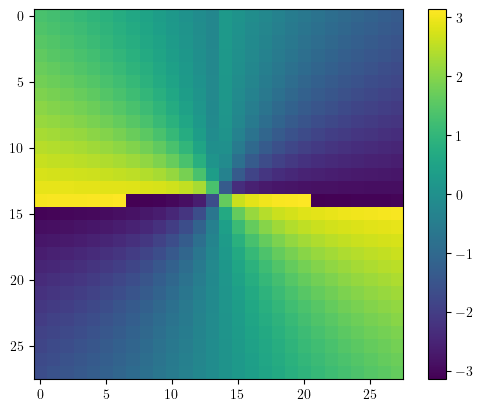

In [23]:
vort = evaller.dictionary[n_zernike,0].cpu() * 2.1
vort = (vort + torch.pi) % (2 * torch.pi) - torch.pi
plt.imshow(vort)
plt.colorbar()